# Plotting rhythms: raster, phase and polar plots

*Bas Cornelissen, 30 September 2020*

*This notebook came out of [a meeting of the Music Cognition Reading Group](https://musicreadinggroup.wordpress.com/2020/09/11/categorical-rhythm-in-songbirds/), and includes suggestions from Henkjan Honing, Carel ten Cate and John Ashley Burgoyne.*

**Are rhythms in human music similarly organized as rhythms in the songs of songbirds? In a recent article Tina Roeske and colleagues conclude that *categorical rhythms are shared between songbirds and humans*. Their analysis makes use of an interesting type of plot they call the *rhythm raster plots*. In this notebook we look at these plots in more detail.**

**Data.** To run this notebook, you need to download the data from https://data.mendeley.com/datasets/s4cjj7h5sv/2 and https://data.mendeley.com/datasets/zhb728dc4z/1 and put it in a data/ directory

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io

In [2]:
def drop_na(x):
    return x[np.logical_not(np.isnan(x))]

In [3]:
corpora = [
    'CubanSalsa',
    'MalianJembe',
    'NorthIndianRaga',
    'PersianZarb',
    'PianoBach',
    'TunisianStambeli',
    'UruguayanCandombe'
]

In [4]:
data = {}
for corpus in corpora:
    mat = scipy.io.loadmat(f'data/IntervalData_{corpus}_corpus.mat')
    data[corpus] = drop_na(mat[f'{corpus}_intervals_ms'][:,0])

## Raster plots

The starting point is a sequence of intervals $i_1, i_2, \dots$ between onsets. 
These can be onsets of song syllables, or of notes in a music recording.
To create their raster plots, the authors look at pairs of consecutive intervals (see figure 1a).
Importantly, they order these pairs so that the first item is always the shortest interval of the two.
Take the intervals $i_j$ and $i_{j+1}$.
If $i_{j+1} \le i_j$ then the $j$-th pair becomes $p_j = (i_{j+1}, i_j)$.
Generally, we write $p = (i_S, i_L)$ for a pair consisting of a shorter and longer interval.
In the raster plot (figure 1b), all these pairs are shown, but sorted by their total cycle duration $\text{cd} = i_S + i_L$.
Longer or slower cycles are shown at the top, and shorter, faster cycles at the bottom of the plot.
Every pair is represented by two points at the same 'row' of the plot.
The shortest interval $i_S$ is plotted on the left, and the longer interval $i_L$ is plotted on the right side.

![title](media/fig1a.jpg)

**Figure 1** *Construction of the raster plots; copied from from Roeske et al (2020)*

The raster plot really shows two overlapping plots with flipped axes. 
One axis for the short intervals, running from 1000ms to 0ms in figure 1b, and one axis for long intervals running the other direction, from 0ms to 1000ms.
Temporal intervals cannot have a duration shorter than zero, so the two plots don't overlap.
But to get some more insight in how these plots work, we will look at general, random sequences of 'intervals' that can take any value.

In [5]:
def raster_points(intervals):
    points = []
    for a, b in zip(intervals[0:], intervals[1:]):
        duration = np.abs(a) + np.abs(b)
        if a <= b:
            points.append([a, b, duration])
        else:
            points.append([b, a, duration])
    return np.asarray(sorted(points, key=lambda p: p[2], reverse=True))

In [6]:
def raster_plot(intervals, large_color='C0', small_color='C3',
                left=None, right=None,
                large_label='larger interval',
                small_label='smaller interval',
                s=.25, alpha=0.25, marker='o',
                **kwargs):
    # Plot properties
    props = dict(s=s, alpha=alpha, marker=marker, edgecolors='none', **kwargs)
    points = raster_points(intervals)
    ys = np.arange(0, -len(points), -1)
    
    # Let matplotlib work out the xlims
    leftmost = points[:, 0].max()
    rightmost = points[:, 1].max()
    plt.plot([-1*leftmost, rightmost], [0,0], '.', alpha=0)
    auto_left, auto_right = plt.xlim()
    if left is None: left = auto_left
    if right is None: right = auto_right
    
    # Zero line
    plt.plot([0, 0], [ys[0], ys[-1]], 'k--', lw=1)

    # Large intervals
    large_ax = plt.gca()
    large_ax.set_xlim(left, right)
    large_ax.scatter(points[:, 1], ys, color=large_color, **props)
    large_ax.tick_params(axis='x', labelcolor=large_color)
    large_ax.set_xlabel(large_label, color=large_color) 
    
    # Small intervals
    small_ax = large_ax.twiny()
    small_ax.set_xlim(-left, -right)
    small_ax.tick_params(axis='x', labelcolor=small_color)
    small_ax.set_xlabel(small_label, color=small_color) 
    small_ax.scatter(points[:, 0], ys, color=small_color, **props)

    # Format the spines
    small_ax.spines['top'].set_color(small_color)
    small_ax.spines['top'].set_linewidth(2)
    small_ax.spines['bottom'].set_color(large_color)
    small_ax.spines['bottom'].set_linewidth(2)
    small_ax.spines['left'].set_linewidth(False)
    large_ax.spines['left'].set_linewidth(False)
    small_ax.spines['right'].set_visible(False)
    large_ax.spines['right'].set_visible(False) 
    plt.yticks([])

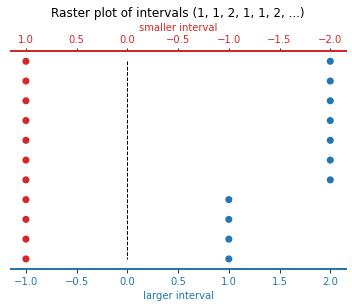

In [7]:
intervals = [1, 1, 2,   1, 1, 2,   1, 1, 2,   1, 1, 2]
raster_plot(intervals, s=50, alpha=1)
plt.title('Raster plot of intervals (1, 1, 2, 1, 1, 2, ...)');
# plt.savefig('raster-simple.pdf')

Here's an example with some more data: (the absolute value of) 50,000 normally distributed intervals ($\mu=10, \sigma=2$):

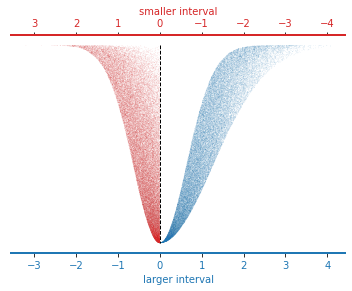

In [8]:
raster_plot(np.abs(np.random.normal(0, 1, 50000)))

This figure illustrates that the tulip-like shape of the graph is not of special interest (even though it looks nice).
We should mostly focus on how the rhythms are distributed *within the tulip*. 
Then we see that actual rhythms (obviously) cluster much more than the random intervals shown above.
Moreover, there seem to be differences between cultures:

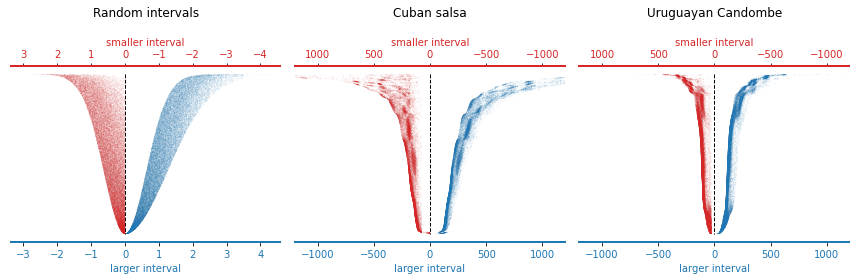

In [9]:
plt.figure(figsize=(12,4))
plt.subplot(131)
raster_plot(np.abs(np.random.normal(0,1, size=50000)))
plt.title('Random intervals\n');

plt.subplot(132)
raster_plot(data['CubanSalsa'], left=-1200, right=1200)
plt.title('Cuban salsa\n');

plt.subplot(133)
raster_plot(data['UruguayanCandombe'], left=-1200, right=1200)
plt.title('Uruguayan Candombe\n');

plt.tight_layout()

Although the raster plots look nice, interpreting them is difficult.
First, the two different horizontal axes can be confusing.
Second, the vertical axis corresponds to cycle duration, but has dimension: it is really the order of the cycles. 
This could, however, be fixed by using a heatmap or hexbin plot.
But third and perhaps most importantly, it is not easy to see where different types of rhythms can be found. 
Fortunately, the authors included a helpful figure in their paper:

<img src="media/fig1b.jpg" style="max-width: 500px;"/>

**Figure 1b** *Small ratio rhythms in a raster plot*

Here we can see that the isochronous rhyhms lie on left-edge of the red side of the plot (the red petal), but also on the left side of the blue petal. That makes sense, since their distance to 0 should be equally large. 
The 1:2 rhythms lie to the right of 1:1 in both petals, and the 1:3 yet more to the right.
This helps, but the plots remain complicated. 
Are there no simpler alternatives?

## Phase plots

Henkjan Honing suggested to so called *phase plots* in which you plot the duration of every interval $i_j$ against the duration of the next interval $i_{j+1}$. Here's a simple example of the a regular rhythm with inter-onset intervals 1, 1, 2, 1, 1, 2, ...:

In [10]:
def phase_points(intervals):
    pairs = zip(intervals[0:], intervals[1:])
    return np.asarray(list(pairs))

Text(0.5, 1.0, 'Phase plot of intervals (1, 1, 2, 1, 1, 2, ...)')

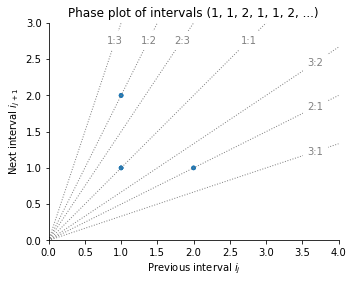

In [11]:
from itertools import combinations
def phase_plot(intervals, s=.25, alpha=.25, **kwargs):
    props = dict(s=s, alpha=alpha, marker='o', edgecolors='none', **kwargs)
    points = phase_points(intervals)
    plt.scatter(points[:, 0], points[:, 1], **props)
    plt.ylabel('Next interval $i_{j+1}$')
    plt.xlabel('Previous interval $i_j$')

    xlim = np.asarray(plt.xlim())
    ylim = np.asarray(plt.ylim())
    
    levels = 3
    line_points = list(combinations(range(1, levels + 1), 2))
    line_points += [[y, x] for x,y in line_points]
    line_points += [[1,1]]
    label_pad = 0.92
    for x, y in line_points:
        plt.axline([0,0], [x, y], linestyle=':', color='0.5', lw=1)
        if y >= x:
            text_y = label_pad * ylim[1]
            text_x = text_y / (y/x)
        else:
            text_x = label_pad * xlim[1]
            text_y = text_x * (y/x)        
        plt.text(text_x, text_y, f'{x}:{y}', backgroundcolor='#fff', color='0.5',
                 ha='center', va='center')
        
    
    plt.xlim(xlim)
    plt.ylim(ylim)
    sns.despine()
    plt.gca().set_aspect('equal')
    
    
intervals = [1, 1, 2,   1, 1, 2,   1, 1, 2,   1, 1, 2]
plt.xlim(0, 4)
plt.ylim(0, 3)
phase_plot(intervals, s=20, alpha=1)
plt.title('Phase plot of intervals (1, 1, 2, 1, 1, 2, ...)')

If we now turn to some actual music, we see that these plots are much easier to interpret:

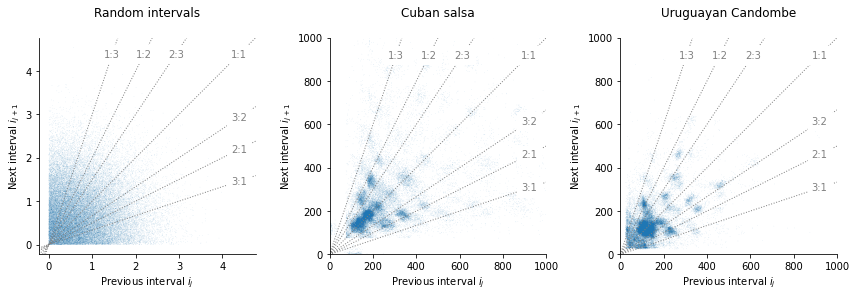

In [12]:
plt.figure(figsize=(12,4))
plt.subplot(131)
phase_plot(np.abs(np.random.normal(0, 1, size=50000)))
plt.title('Random intervals\n');

plt.subplot(132)
plt.xlim(0, 1000)
plt.ylim(0, 1000)
phase_plot(data['CubanSalsa'])
plt.title('Cuban salsa\n');

plt.subplot(133)
plt.xlim(0, 1000)
plt.ylim(0, 1000)
phase_plot(data['UruguayanCandombe'])
plt.title('Uruguayan Candombe\n');

plt.tight_layout()

## Polar plot

The raster plots had one advantage: they also showed the cycle duration.
One nice way of showing this is by overlaying the phase plots with a polar coordinate system:

In [13]:
def polar_points(intervals):
    """Convert intervals to a polar coordinates"""
    points = phase_points(intervals)
    r = points.sum(axis=1)
    theta = np.arctan(points[:, 1] / points[:, 0])
    return np.array([theta, r]).T

In [14]:
def polar_plot(intervals, ax=None, levels=3, s=.25, alpha=.25, labels=True, **kwargs):
    if ax is None: ax = plt.gcf().add_subplot(111, polar=True)    
    points = polar_points(intervals)
    ax.scatter(points[:, 0], points[:, 1], s=s, alpha=alpha, marker='o', edgecolors='none', **kwargs)

    # Set theta ticks: the ratios
    line_points = list(combinations(range(1, levels + 1), 2))
    line_points += [[y, x] for x,y in line_points] + [[1,1]]
    theta_ticks = [np.arctan(x/y) for x, y in line_points]
    theta_labels = [f'{x}:{y}' for x, y in line_points]
    plt.xticks(theta_ticks, theta_labels)
    ax.set_thetamin(0)
    ax.set_thetamax(90)
    
    # Bit hacky: axis labels
    if labels:
        ax.text(0.5*np.sqrt(2) + .05, 0.5*np.sqrt(2) + .05, "Ratio",
                 rotation=-45, ha="left", va="bottom", transform=ax.transAxes)
        ax.text(.5, -.1, "cycle duration",
                 rotation=0, ha="center", va="top", transform=ax.transAxes)

# intervals = np.abs(np.random.normal(0, 1, 50000))
# polar_plot(intervals)

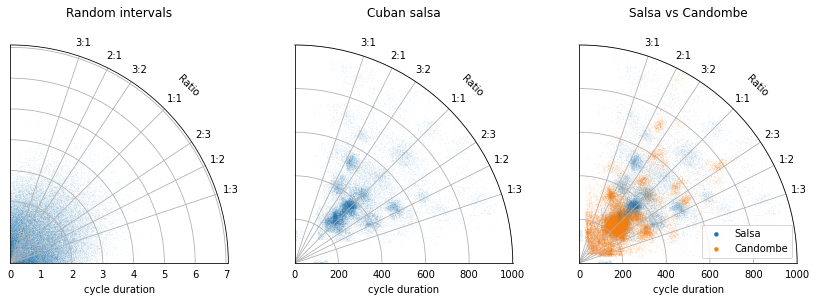

In [15]:
plt.figure(figsize=(12,4))
ax1 = plt.subplot(131, projection='polar')
polar_plot(np.abs(np.random.normal(0, 1, 50000)), ax=ax1)
plt.title('Random intervals\n');

ax2 = plt.subplot(132, projection='polar')
plt.xlim(0, 1000)
plt.ylim(0, 1000)
polar_plot(data['CubanSalsa'], ax=ax2)
plt.title('Cuban salsa\n');

ax3 = plt.subplot(133, projection='polar')
plt.xlim(0, 1000)
plt.ylim(0, 1000)
polar_plot(data['CubanSalsa'], ax=ax3, label='Salsa')
polar_plot(data['UruguayanCandombe'], ax=ax3, alpha=.5, label='Candombe', labels=False)
l = plt.legend()
for handle in l.legendHandles:
    handle.set_alpha(1)
    handle.set_sizes([20])
plt.title('Salsa vs Candombe\n');

plt.tight_layout()

## Combined plots

In [16]:
def plot_combined(intervals, title='', bound=None, **kwargs):
    plt.figure(figsize=(12, 5))
    
    ax1 = plt.subplot(131)
    leftbound = -1*bound if bound is not None else None
    raster_plot(intervals, left=leftbound, right=bound, **kwargs)
    
    ax2 = plt.subplot(132)
    if bound: plt.ylim(0, bound)
    if bound: plt.xlim(0, bound)
    phase_plot(intervals, **kwargs)
        
    ax3 = plt.subplot(133, projection="polar")
    polar_plot(intervals, ax=ax3, **kwargs)
    if bound: plt.ylim(0, bound*1.5)
        
    plt.suptitle(title, fontweight='bold' )
    plt.tight_layout()

In [26]:
def show_corpus(corpus, save=False, **kwargs):
    mat = scipy.io.loadmat(f'data/IntervalData_{corpus}_corpus.mat')
    intervals = drop_na(mat[f'{corpus}_intervals_ms'][:,0])
    plot_combined(intervals, corpus, **kwargs)
    if save:
        plt.savefig(f'figures/combined-{corpus}.png', dpi=300)

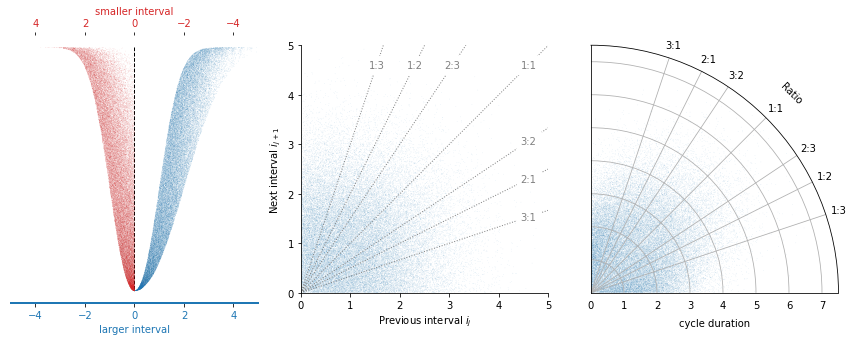

In [27]:
plot_combined(np.abs(np.random.normal(1, 1, 50000)), bound=5)

### Musical traditions

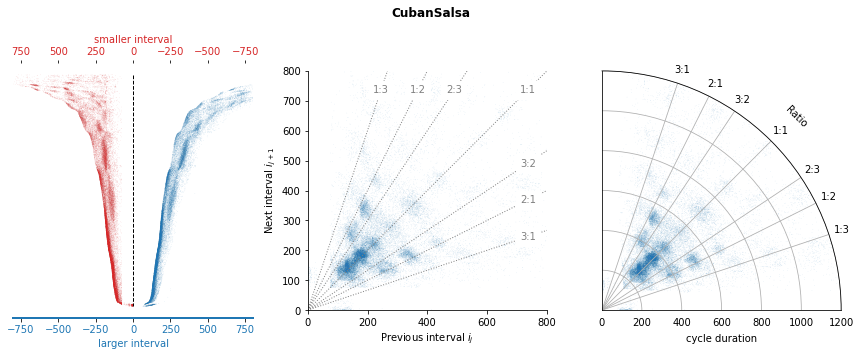

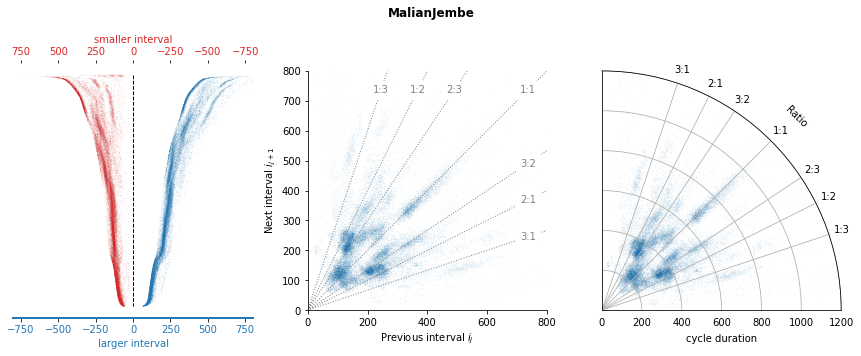

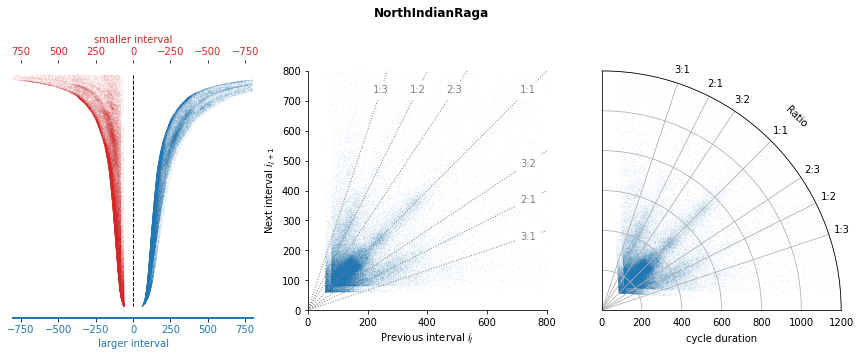

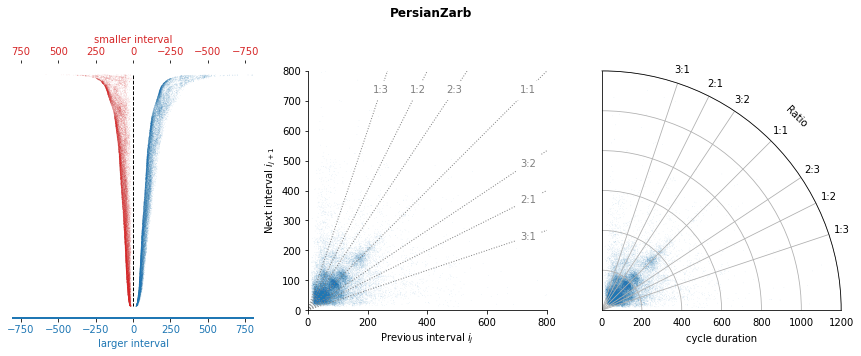

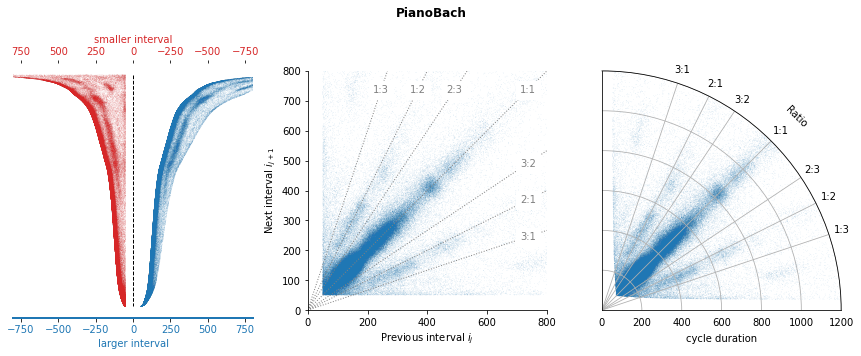

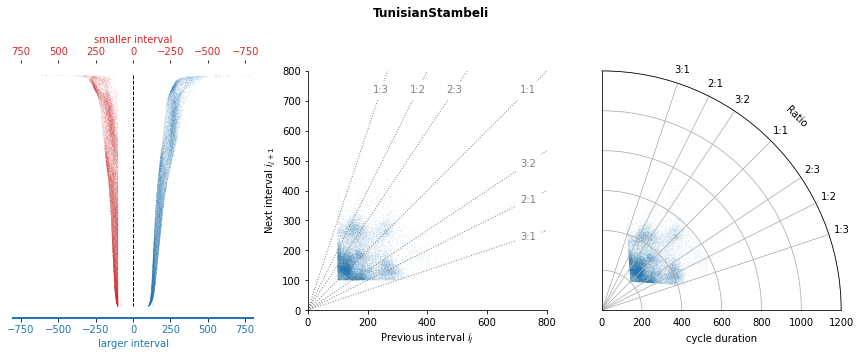

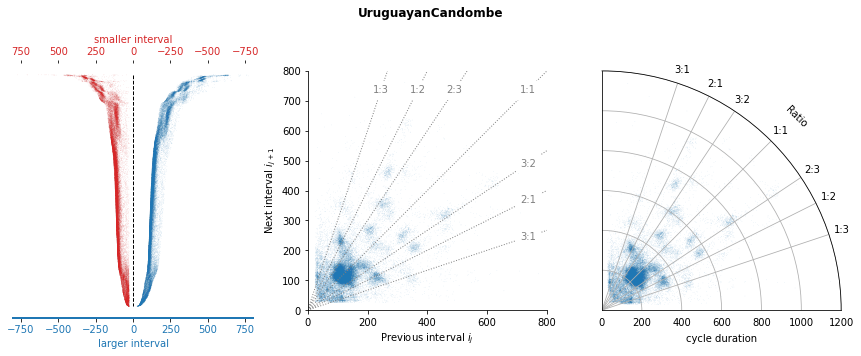

In [28]:
for corpus in corpora:
    show_corpus(corpus, bound=800)

### Thrush Nightingale

In [20]:
mat = scipy.io.loadmat('data/IntervalData_ThrushNightingale_3corpora.mat')
nightingale_songs = drop_na(mat['ThrushNightingaleSongs_intervals_ms'][:,0])
nightingale_stable = drop_na(mat['ThrushNightingaleStableRhythms_intervals_ms'][:, 0])
nightingale_same_syll = drop_na(mat['ThrushNightingaleSameSyllableEpochs_intervals_ms'][:, 0])

Text(0.5, 0.98, 'Thrush Nightingale Songs')

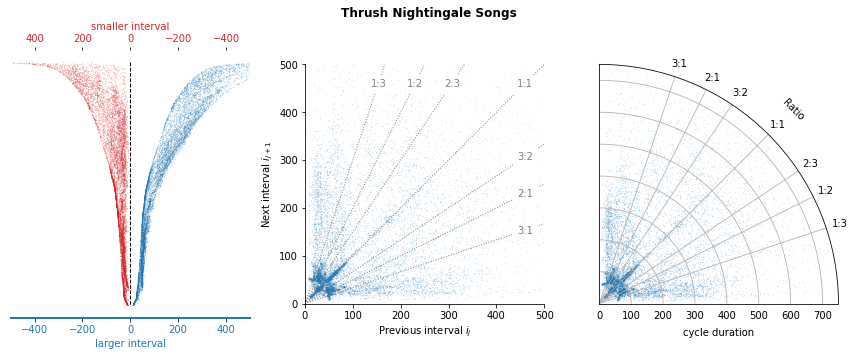

In [21]:
plot_combined(nightingale_songs, bound=500, s=.5, alpha=.5)
plt.suptitle('Thrush Nightingale Songs', fontweight='bold')

Text(0.5, 0.98, 'Thrush Nightingale: Stable Rhythms')

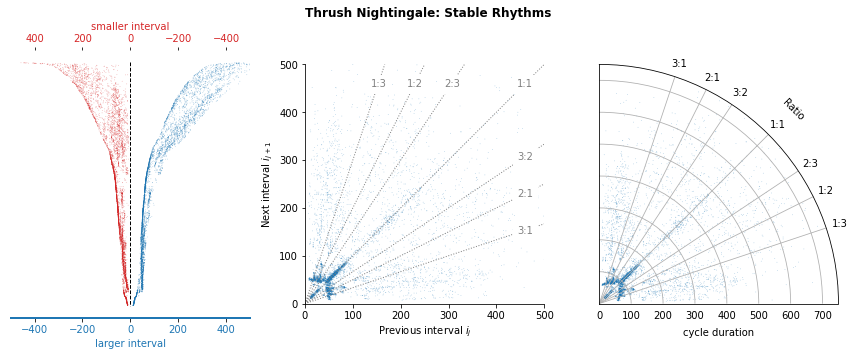

In [22]:
plot_combined(nightingale_stable, bound=500, s=.5, alpha=.5)
plt.suptitle('Thrush Nightingale: Stable Rhythms', fontweight='bold')

Text(0.5, 0.98, 'Thrush Nightingale: Same Syllable Epochs')

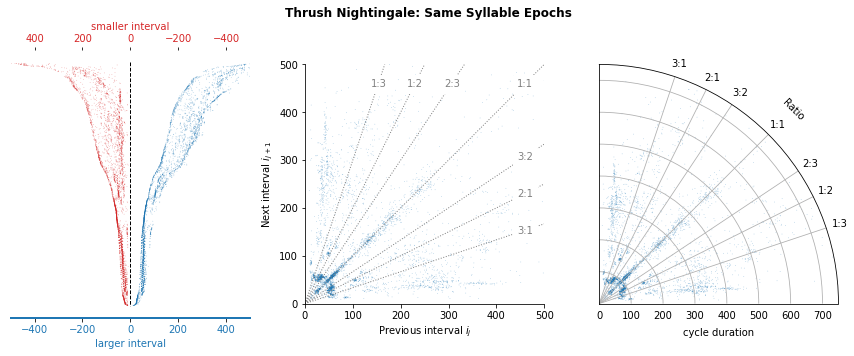

In [23]:
plot_combined(nightingale_same_syll, bound=500, s=.5, alpha=.5)
plt.suptitle('Thrush Nightingale: Same Syllable Epochs', fontweight='bold')

### Zebra Finch Rhythm

In [24]:
mat = scipy.io.loadmat('data/IntervalData_ZebraFinch_corpus.mat')
zebrafinch = drop_na(mat['ZebraFinch_intervals_ms'])

Text(0.5, 0.98, 'Zebra Finch')

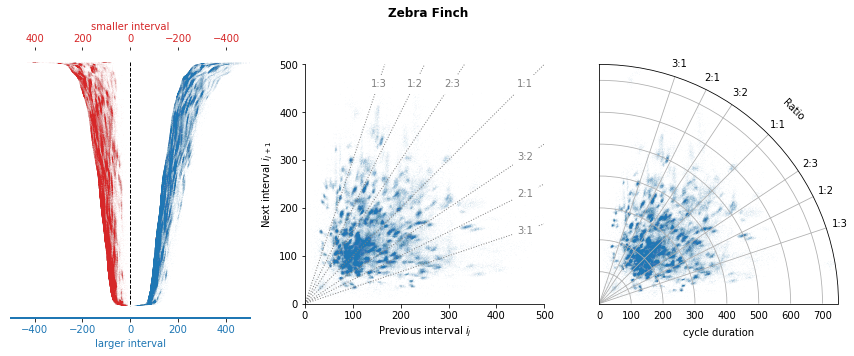

In [25]:
plot_combined(zebrafinch, bound=500, s=.1, alpha=.25)
plt.suptitle('Zebra Finch', fontweight='bold')